##  1. Imports

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb


##  2. Load and Prepare Data

In [63]:
file_path = '../../Data/final/sales_forecast_data.csv'
df = pd.read_csv(file_path)
df['SalesDate'] = pd.to_datetime(df['SalesDate'])
df = df.sort_values(by=['StoreID', 'ItemID', 'SalesDate'])


##  3. Feature Engineering

In [64]:
df['DayOfWeek'] = df['SalesDate'].dt.dayofweek
df['DayOfMonth'] = df['SalesDate'].dt.day
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)


##  4. Define Target and Features

In [65]:
target_col = 'SalesQuantity'
feature_cols = ['Lag_1', 'Lag_7', 'RollingAvg_7', 'Month', 'DayOfWeek', 
                'DayOfMonth', 'IsWeekend']

# Drop missing features if any
feature_cols = [col for col in feature_cols if col in df.columns]

X = df[feature_cols]
y = df[target_col]


##  5. Train-Test Split

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

##  6. Scale Features

In [67]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


##  7. Train XGBoost Model

In [68]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='rmse',
    early_stopping_rounds=10
)

model.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=False
)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

##  8. Predictions & Evaluation

In [69]:
y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Square Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error: 0.9914
Root Mean Square Error: 1.3993
R² Score: 0.2323


##  9. Plot Predictions vs Actual (First 100 Days)

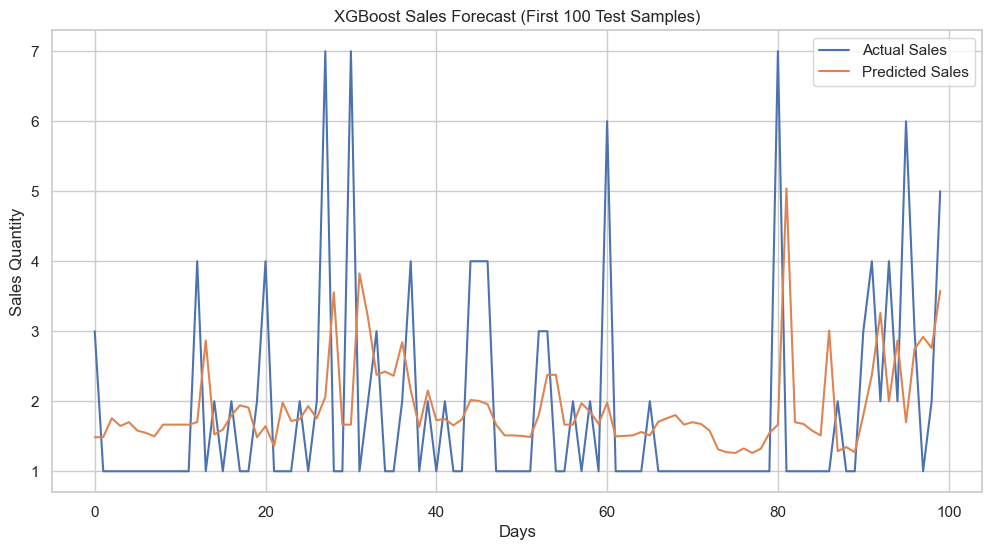

In [70]:
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100].values, label='Actual Sales')
plt.plot(y_pred[:100], label='Predicted Sales')
plt.title("XGBoost Sales Forecast (First 100 Test Samples)")
plt.xlabel("Days")
plt.ylabel("Sales Quantity")
plt.legend()
plt.savefig('../../artifacts/plots/sales_forecast_first100_plot.png')
plt.show()


##  10. Forecast Next 7 Days

In [71]:
last_row = df.iloc[-1:].copy()

future_preds = []
current_row = last_row.copy()

for i in range(7):
    X_pred = current_row[feature_cols].values.reshape(1, -1)
    next_pred = model.predict(X_pred)[0]
    future_preds.append(next_pred)

    new_row = current_row.copy()
    
    if 'Lag_1' in new_row.columns:
        new_row['Lag_1'] = next_pred
    if 'Lag_7' in new_row.columns:
        new_row['Lag_7'] = current_row['Lag_1'].values[0] if 'Lag_1' in current_row else next_pred
    if 'RollingAvg_7' in new_row.columns:
        new_row['RollingAvg_7'] = current_row['RollingAvg_7'].values[0] if 'RollingAvg_7' in current_row else next_pred

    new_row['SalesDate'] = pd.to_datetime(new_row['SalesDate']) + pd.Timedelta(days=1)
    new_row['DayOfMonth'] = new_row['SalesDate'].dt.day
    new_row['DayOfWeek'] = new_row['SalesDate'].dt.dayofweek
    new_row['Quarter'] = new_row['SalesDate'].dt.quarter
    new_row['IsWeekend'] = 1 if new_row['DayOfWeek'].values[0] >= 5 else 0

    current_row = new_row.copy()

print("Forecast for next 7 days:", future_preds)


Forecast for next 7 days: [np.float32(1.1575333), np.float32(1.1575333), np.float32(1.1575333), np.float32(1.2833611), np.float32(1.5319458), np.float32(1.383582), np.float32(1.383582)]


##  Sales Forecast: Actual vs Predicted + 7-Day Projection"

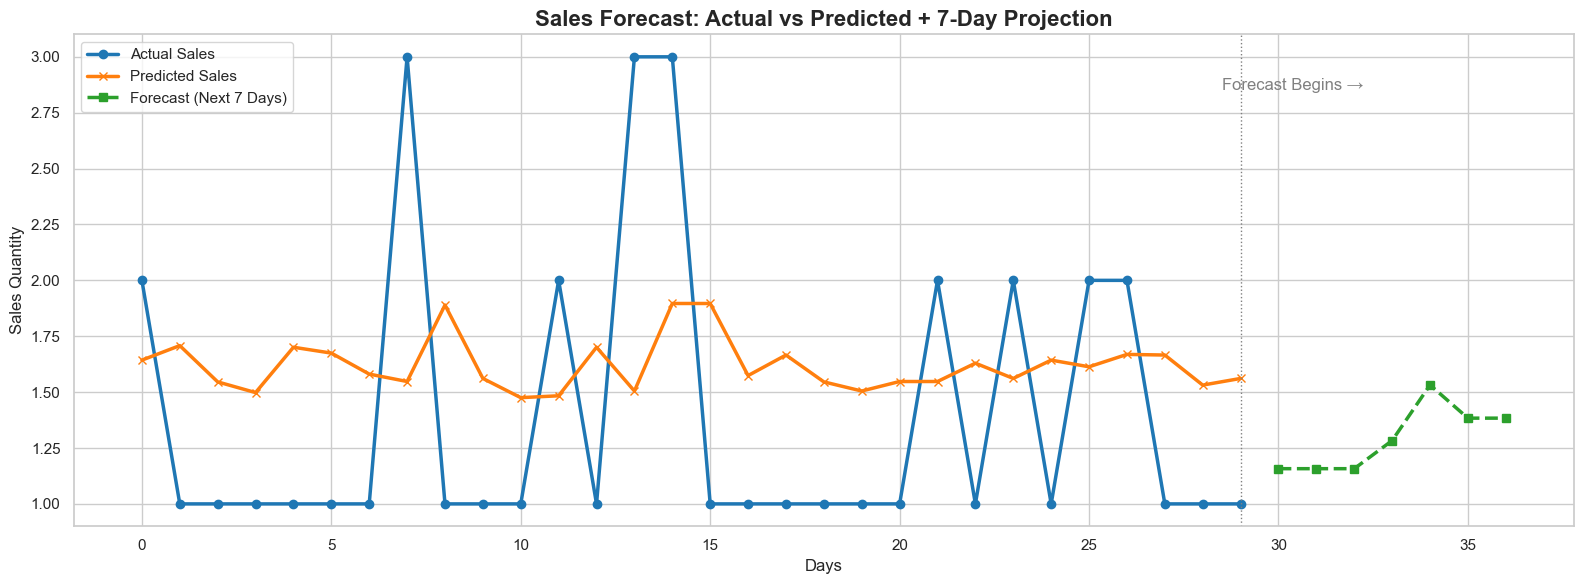

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Use seaborn style for cleaner visuals
sns.set(style="whitegrid")

# Prepare values
y_test_plot = y_test[-30:].values
y_pred_plot = y_pred[-30:]
forecasted_values = future_preds
x_actual = np.arange(len(y_test_plot))
x_forecast = np.arange(len(y_test_plot), len(y_test_plot) + len(forecasted_values))

# Plot
plt.figure(figsize=(16, 6))
plt.plot(x_actual, y_test_plot, label='Actual Sales', linewidth=2.5, color='#1f77b4', marker='o')
plt.plot(x_actual, y_pred_plot, label='Predicted Sales', linewidth=2.5, color='#ff7f0e', marker='x')
plt.plot(x_forecast, forecasted_values, label='Forecast (Next 7 Days)', linewidth=2.5, color='#2ca02c', linestyle='--', marker='s')

# Vertical line to mark prediction/forecast boundary
plt.axvline(x=len(y_test_plot)-1, color='gray', linestyle=':', linewidth=1)
plt.text(len(y_test_plot)-1.5, max(max(y_test_plot), max(forecasted_values)) * 0.95, 'Forecast Begins →', color='gray')

# Labels & Legend
plt.title("Sales Forecast: Actual vs Predicted + 7-Day Projection", fontsize=16, weight='bold')
plt.xlabel("Days", fontsize=12)
plt.ylabel("Sales Quantity", fontsize=12)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig('../../artifacts/plots/sales_forecast_with_7_day_projection_plot.png')
plt.show()



##  11. Save Model & Compare Baseline

In [73]:
import pickle

# Save the model to a .pkl file using pickle
with open('../../artifacts/models/sales_forecast_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model saved to 'sales_forecast_model.pkl'")

#Save predictions as well


Model saved to 'sales_forecast_model.pkl'
